## Importing model

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
from model import get_resnet50

model_normal = get_resnet50(pretrained=False) 
model_aug = get_resnet50(pretrained=False) 

#we want just the architecture, not resnet50 trained on imagenet.

/Users/aryan/Desktop/Academics /Semester 4/AI Software tools and techniques/data_augmentation_cs203/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/aryan/Desktop/Academics /Semester 4/AI Software tools and techniques/data_augmentation_cs203/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

## Importing datasets

In [4]:
train_normal_images = np.load("train_dataset/train_images.npy")
train_normal_labels = np.load("train_dataset/train_labels.npy")

train_aug_images = np.load("augmented_train/train_images.npy")
train_aug_labels = np.load("augmented_train/train_labels.npy")

## Training

In [5]:
# Normalize images and convert to torch tensors
def preprocess_images(images):
    images = images / 255.0  # Normalize to [0,1]
    images = np.transpose(images, (0, 3, 1, 2))  # Convert to (N, C, H, W)
    return torch.tensor(images, dtype=torch.float32)

train_normal_images = preprocess_images(train_normal_images)
train_aug_images = preprocess_images(train_aug_images)

# Convert labels to tensors
train_normal_labels = torch.tensor(train_normal_labels, dtype=torch.long)
train_aug_labels = torch.tensor(train_aug_labels, dtype=torch.long)

# Create DataLoader
BATCH_SIZE = 32

train_normal_loader = DataLoader(TensorDataset(train_normal_images, train_normal_labels), batch_size=BATCH_SIZE, shuffle=True)
train_aug_loader = DataLoader(TensorDataset(train_aug_images, train_aug_labels), batch_size=BATCH_SIZE, shuffle=True)

In [6]:
# Train Function
def train_model(model, train_loader, num_epochs=20, lr=0.001):
    model.to(device)  # Move model to MPS
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accuracies = []

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            # Move images and labels to MPS and ensure float32 dtype
            images, labels = images.to(device, dtype=torch.float32), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = total_loss / len(train_loader)
        epoch_acc = correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    return train_losses, train_accuracies

## Inference and Evaluation

In [7]:
test_images = np.load("test_dataset/test_images.npy")
test_labels = np.load("test_dataset/test_labels.npy")

In [8]:
test_images = preprocess_images(test_images)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)
test_loader = DataLoader(TensorDataset(test_images, test_labels_tensor), batch_size=BATCH_SIZE, shuffle=False)

In [9]:

# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return accuracy, precision, recall, f1

In [10]:
# Train models
print("\nTraining model_normal on non-augmented data...")
train_losses_normal, train_accuracies_normal = train_model(model_normal, train_normal_loader, num_epochs=20)

print("\nTraining model_aug on augmented data...")
train_losses_aug, train_accuracies_aug = train_model(model_aug, train_aug_loader, num_epochs=20)


Training model_normal on non-augmented data...
Epoch [1/20], Loss: 4.0240, Accuracy: 0.3304
Epoch [2/20], Loss: 1.0265, Accuracy: 0.5536
Epoch [3/20], Loss: 0.9994, Accuracy: 0.4732
Epoch [4/20], Loss: 0.7276, Accuracy: 0.5714
Epoch [5/20], Loss: 0.6272, Accuracy: 0.6964
Epoch [6/20], Loss: 0.5406, Accuracy: 0.7321
Epoch [7/20], Loss: 0.5309, Accuracy: 0.7589
Epoch [8/20], Loss: 0.5029, Accuracy: 0.8036
Epoch [9/20], Loss: 0.4608, Accuracy: 0.7589
Epoch [10/20], Loss: 0.3056, Accuracy: 0.9018
Epoch [11/20], Loss: 0.1461, Accuracy: 0.9464
Epoch [12/20], Loss: 0.0939, Accuracy: 0.9554
Epoch [13/20], Loss: 0.0556, Accuracy: 0.9732
Epoch [14/20], Loss: 0.1193, Accuracy: 0.9643
Epoch [15/20], Loss: 0.7152, Accuracy: 0.8304
Epoch [16/20], Loss: 0.5602, Accuracy: 0.8125
Epoch [17/20], Loss: 0.4408, Accuracy: 0.8214
Epoch [18/20], Loss: 0.3520, Accuracy: 0.8393
Epoch [19/20], Loss: 0.3529, Accuracy: 0.8571
Epoch [20/20], Loss: 0.1427, Accuracy: 0.9554

Training model_aug on augmented data...


In [11]:
# Visualization Function
def plot_training_curves(train_losses, train_accuracies):
    plt.figure(figsize=(12, 5))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-', color='#2E86C1', label="Training Loss")
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Training Loss Curve", fontsize=14, fontweight="bold")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='s', linestyle='-', color='#28B463', label="Training Accuracy")
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title("Training Accuracy Curve", fontsize=14, fontweight="bold")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    plt.tight_layout()
    plt.show()

#### Normal training

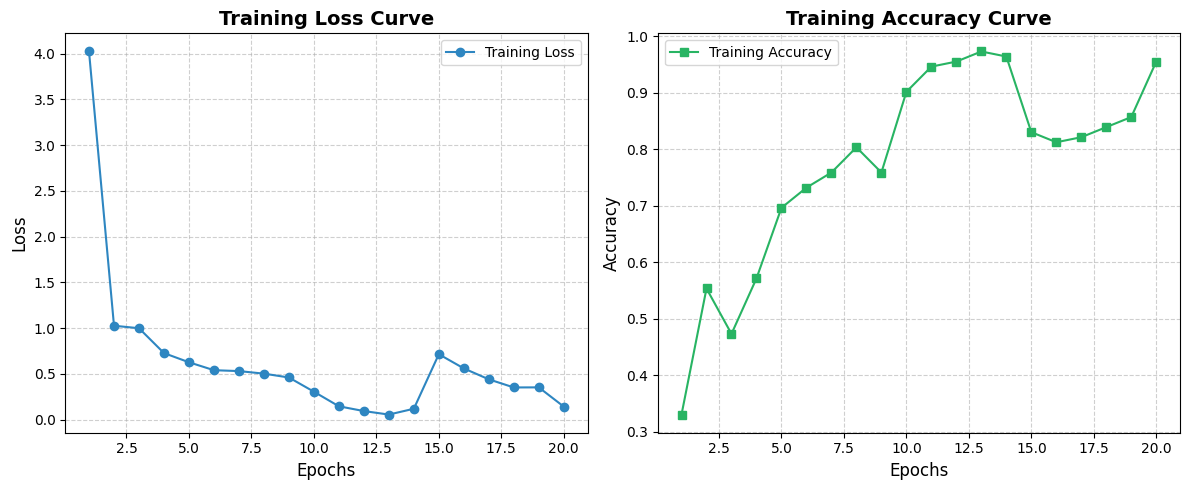

In [12]:
plot_training_curves(train_losses_normal, train_accuracies_normal)

#### Augmented trainset training

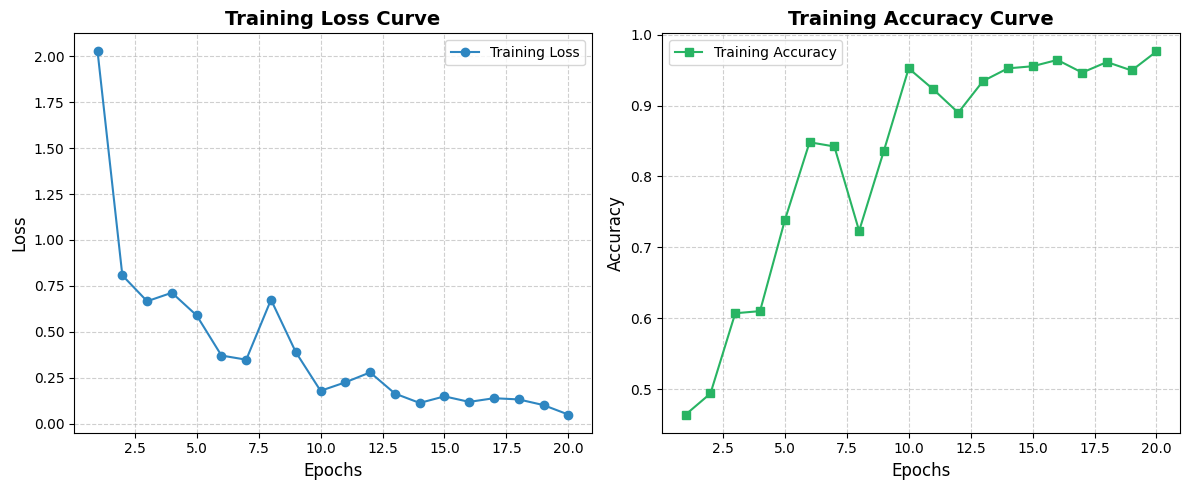

In [13]:
plot_training_curves(train_losses_aug, train_accuracies_aug)

## Scores 

In [14]:
# Evaluate models
acc_normal, prec_normal, rec_normal, f1_normal = evaluate_model(model_normal, test_loader)
acc_aug, prec_aug, rec_aug, f1_aug = evaluate_model(model_aug, test_loader)

print("\n📊 ResNet50 (Normal Training) Results:")
print(f"   Accuracy:  {acc_normal:.4f}")
print(f"   Precision: {prec_normal:.4f}")
print(f"   Recall:    {rec_normal:.4f}")
print(f"   F1 Score:  {f1_normal:.4f}")

print("\n📊 ResNet50 (Augmented Training) Results:")
print(f"   Accuracy:  {acc_aug:.4f}")
print(f"   Precision: {prec_aug:.4f}")
print(f"   Recall:    {rec_aug:.4f}")
print(f"   F1 Score:  {f1_aug:.4f}")


📊 ResNet50 (Normal Training) Results:
   Accuracy:  0.5357
   Precision: 0.5200
   Recall:    0.9286
   F1 Score:  0.6667

📊 ResNet50 (Augmented Training) Results:
   Accuracy:  0.6071
   Precision: 0.6000
   Recall:    0.6429
   F1 Score:  0.6207


## Training parameters

In [16]:
def get_training_info(model, optimizer, criterion):
    print("📝 Training Parameters:")
    print(f"- Model: {model.__class__.__name__}")
    print(f"- Optimizer: {optimizer.__class__.__name__}")
    for param_group in optimizer.param_groups:
        print(f"- Learning Rate: {param_group['lr']}")
    print(f"- Loss Function: {criterion.__class__.__name__}")

# Example usage:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_aug.parameters(), lr=0.001)

get_training_info(model_aug, optimizer, criterion)

📝 Training Parameters:
- Model: ResNet
- Optimizer: Adam
- Learning Rate: 0.001
- Loss Function: CrossEntropyLoss


## Interpretation 

### Traintime 
We observe that the accuracy for augmented dataset rises quicker on average as compared to normal. 
This is because our augmented data offers more diversity and improves learning. 

### Testtime 
Here we observe, normal gives an accuracy of around 50%. This indicates that there is near to no learning that helps us, as this is binary classification and you can be right ½ times. 
However, for the augmented dataset, our accuracy is better. And it is reasonable. 
We also feel that we could get  a much higher accuracy if we used other strategies like more augmentation, validation, k-folds etc. 
For augmented dataset training, the model generalizes better. 

### Extra
Recall drops after augmentation (from 92.86% → 64.29%), which means the first model was aggressively predicting “dog” even when unsure. Because dog is positive class. 
F1 score is more balanced (from 66.67% → 62.07%), suggesting the second model is more reliable overall rather than just favoring recall.
Precision improves (from 52% → 60%), reducing false positives.
